<a href="https://colab.research.google.com/github/MariaanaT/Higgs-DNN/blob/master/Higgs_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Searching Higgs boson with deep neural network

This work aims to replicate work presented in the article *Baldi, P., P. Sadowski, and D. Whiteson. “[Searching for Exotic Particles in High-energy Physics with Deep Learning.](https://arxiv.org/pdf/1402.4735.pdf)” Nature Communications 5 (July 2, 2014).* 

The abstract of the article states that "*Collisions at high-energy particle colliders are a traditionally fruitful source of exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification problems, hence machine learning approaches are often used. [...] Using benchmark datasets, we show that deep learning methods need no manually constructed inputs and yet improve the classification metric by as much as 8% over the best current approaches. This demonstrates that deep learning approaches can improve the power of collider searches for exotic particles.*"

In this notebook, **deep** neural network is trained and evaluated. See the other notebook to compare the model behavior to **shallow** neural network. 

The dataset used in the original article, and used in this work as well, can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS). Dataset description can be found from the article. The work desctibed in the article uses Pylearn2 to train neural networks, but Tensorflow and Keras are used in this work. See also [code in GitHub](https://github.com/uci-igb/higgs-susy) used in the original article. 



### Load packages and the dataset

Load packages 

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import Adam
from keras.optimizers import Nadam

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

Set some constants. 

The original article used 2.6 million datapoints for training and testing, and 100000 datapoints for validation. We will use more training data as the dataset contains 11 million datapoints. 

In [2]:
dataRowsTraining = 5000000
dataRowsValidation = 1000000
nrows = dataRowsTraining + dataRowsValidation

#### Load the dataset 

Get dataset from Google Drive. Needed only when working with Google Colab. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We need only the class label and low level features, that is, columns 1-22. High level features which have been derived from low level features, are in columns 23-29 and are left out.

In total, dataset contains 11 million datapoints, created simulating 8 TeV collisions of protons in the  Large  Hadron Collider. Positive examples consist 53 % of the dataset.  

In [5]:
#path = 'HIGGS.csv.gz' #link in own computer
path = '/content/drive/My Drive/datasets/HIGGS.csv.gz' #link in Google Drive
dataset = pd.read_csv(path, 
                      compression='gzip', 
                      usecols = list(range(0,22)), 
                      nrows = nrows,
                      header = None)

Print the firs few roads to make sure loading was done correctly. 

In [6]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


Rename columns to be more descriptive. 

In [7]:
dataset.columns = ['class label', 'lepton pT', 'lepton eta', 'lepton phi', 
                   'missing energy magnitude', 'missing energy phi',
                   'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
                   'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                   'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 
                   'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag']

#### Summarize the dataset 

Print summary of the dataset. 

In [8]:
dataset.describe()

,class label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,5.297242e-01,9.911388e-01,-6.317132e-06,3.633206e-04,9.981901e-01,3.190455e-05,9.908860e-01,-5.361822e-04,-8.940377e-05,1.000497e+00,9.924728e-01,3.722284e-04,-2.034389e-04,9.994989e-01,9.921424e-01,1.281615e-04,-2.103781e-04,1.000315e+00,9.859461e-01,5.495551e-05,1.010016e-05,9.995073e-01
std,4.991157e-01,5.648960e-01,1.008915e+00,1.006282e+00,5.999452e-01,1.006247e+00,4.750803e-01,1.009190e+00,1.005880e+00,1.027797e+00,5.000136e-01,1.009539e+00,1.006107e+00,1.049401e+00,4.874518e-01,1.008500e+00,1.006410e+00,1.193803e+00,5.058094e-01,1.007736e+00,1.006360e+00,1.400049e+00
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,3.943779e-04,-1.743944e+00,1.376856e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00
25%,0.000000e+00,5.903873e-01,-7.392965e-01,-8.713760e-01,5.765905e-01,-8.711470e-01,6.789927e-01,-6.872450e-01,-8.680962e-01,0.000000e+00,6.563349e-01,-6.944718e-01,-8.701791e-01,0.000000e+00,6.508527e-01,-6.988981e-01,-8.716891e-01,0.000000e+00,6.172805e-01,-7.133574e-01,-8.720338e-01,0.000000e+00
50%,1.000000e+00,8.531884e-01,9.198132e-04,9.714414e-04,8.913502e-01,3.782700e-04,8.946361e-01,-1.015666e-03,-4.961938e-04,1.086538e+00,8.898859e-01,6.027267e-05,-2.032892e-04,0.000000e+00,8.972494e-01,1.728937e-04,-1.972152e-04,0.000000e+00,8.679899e-01,3.721330e-04,-2.642369e-04,0.000000e+00
75%,1.000000e+00,1.236043e+00,7.382142e-01,8.709940e-01,1.292679e+00,8.714819e-01,1.170740e+00,6.862039e-01,8.683126e-01,2.173076e+00,1.201749e+00,6.955639e-01,8.693178e-01,2.214872e+00,1.221447e+00,7.001541e-01,8.713947e-01,2.548224e+00,1.220930e+00,7.141017e-01,8.710505e-01,3.101961e+00
max,1.000000e+00,1.039601e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,8.848616e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,1.142382e+01,2.730009e+00,1.742884e+00,2.548224e+00,1.288257e+01,2.498009e+00,1.743372e+00,3.101961e+00


The original article describes the **signal and background processes** in the following way: 

"*The  signal  process  is  the  fusion  of  two  gluons  into  a heavy electrically-neutral Higgs boson (gg→H$^0$), which decays to a heavy electrically-charged Higgs bosons (H$^±$) and a W boson.  The H± boson subsequently decays to a second W boson and the light Higgs boson, h$^0$ [...].  The  light  Higgs  boson  decays  predominantly to a pair of bottom quarks, giving the process*:

$gg$ → H$^0$ → W$^∓$H$^±$ → W$^∓$W$^±$h$^0$ → W$^∓$W$^±$ $b \bar b$,

[...].  *The background process, which mimics W$^∓$W$^±$ $b \bar b$ without the Higgs boson intermediate state, is the production of a pair of top quarks, each of which decay to W$b$, also giving W$^∓$W$^±$ $b \bar b$."*

The **low level features** in the dataset are described in the article as follows: 

"*We  focus  on  the  semi-leptonic  decay  mode,  in  which one W boson decays to a lepton and neutrino (lν) and the other decays to a pair of jets (jj), giving decay products lνb jjb.   We  consider  events  which  satisfy  the  requirements:*
- *Exactly one electron or muon, with pT > 20 GeV and |η| < 2.5;*
- *at least four jets, each with pT > 20 GeV and |η| < 2.5;*
- *b-tags  on  at  least  two  of  the  jets,  indicating  that they are likely due to b-quarks rather than gluons or lighter quarks.*"

### Get training and validation sets from the dataset 

#### Split input and output variables
Split dataset into input (X) and output (y) variables. Trivially, class label is the output variable.

In [9]:
X = dataset.iloc[:,1:23]
y = dataset.iloc[:,0] 
X.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


#### Standardize and scale

Data needs to be standardized: zero mean and standard deviation one. But, for features always greater than zero, scaling is done so that values are between [0,2]. 

In [10]:
standardizedColumns = ['lepton eta', 'lepton phi', 'missing energy phi',
                        'jet 1 eta', 'jet 1 phi', 'jet 2 eta', 'jet 2 phi', 
                        'jet 3 eta', 'jet 3 phi', 'jet 4 eta', 'jet 4 phi']
X_standardized = StandardScaler().fit_transform(X[standardizedColumns]) 
X_df_standardized = pd.DataFrame(X_standardized)
X_df_standardized.columns = standardizedColumns

In [11]:
scaledColums = ['lepton pT', 'missing energy magnitude', 
             'jet 1 pt', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 b-tag', 
             'jet 3 pt', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 b-tag']
X_scaled = MinMaxScaler(feature_range=(0, 2)).fit_transform(X[scaledColums]) 
X_df_scaled = pd.DataFrame(X_scaled)
X_df_scaled.columns = scaledColums

Combine to a single training set again. 

In [12]:
X_combined = X_df_standardized.merge(X_df_scaled, left_index=True, right_index=True)
X_combined.tail()

,lepton eta,lepton phi,missing energy phi,jet 1 eta,jet 1 phi,jet 2 eta,jet 2 phi,jet 3 eta,jet 3 phi,jet 4 eta,jet 4 phi,lepton pT,missing energy magnitude,jet 1 pt,jet 1 b-tag,jet 2 pt,jet 2 b-tag,jet 3 pt,jet 3 b-tag,jet 4 pt,jet 4 b-tag
5999995,0.216194,-0.414700,-1.154154,-0.256572,-1.518784,0.501957,0.745679,-1.031601,0.307135,-0.398024,1.312725,0.223488,0.070915,0.075381,2.0,0.075906,0.0,0.075661,0.0,0.099212,2.0
5999996,-0.188293,-1.245659,1.169012,-0.654944,-0.700900,0.339346,1.464234,1.077721,0.404146,-1.851715,0.744226,0.132610,0.103179,0.135997,0.0,0.100959,1.0,0.113459,1.0,0.049937,0.0
5999997,0.513526,-0.363972,0.899707,0.231091,-1.517131,-0.684430,0.385574,-1.315912,-0.601351,0.896165,-0.574839,0.049543,0.162591,0.196361,2.0,0.140297,2.0,0.052497,0.0,0.011629,0.0
5999998,1.884341,0.858579,-0.378351,0.028961,-0.413755,-0.365943,0.326568,-2.146283,1.405681,1.199465,1.686026,0.027267,0.096537,0.188074,2.0,0.128144,1.0,0.152895,0.0,0.027069,0.0
5999999,-1.282049,1.343809,0.788375,-0.611771,-0.781916,2.258925,0.674540,-1.230168,-1.288149,-0.933551,0.034017,0.258277,0.193407,0.199348,2.0,0.069885,0.0,0.201709,0.0,0.119242,1.0


#### Training and validation sets

Separate validation set from the training set. 

In [15]:
X_train = X_combined.iloc[0:dataRowsTraining,:]
y_train = y.iloc[0:dataRowsTraining]

In [16]:
validationStartRow = dataRowsTraining + 1
validationEndRow = dataRowsTraining + dataRowsValidation
X_validation = X_combined.iloc[validationStartRow:validationEndRow,:].reset_index(drop=True)
y_validation = y.iloc[validationStartRow:validationEndRow].reset_index(drop=True)
X_validation.head()

,lepton eta,lepton phi,missing energy phi,jet 1 eta,jet 1 phi,jet 2 eta,jet 2 phi,jet 3 eta,jet 3 phi,jet 4 eta,jet 4 phi,lepton pT,missing energy magnitude,jet 1 pt,jet 1 b-tag,jet 2 pt,jet 2 b-tag,jet 3 pt,jet 3 b-tag,jet 4 pt,jet 4 b-tag
0,1.364976,-0.843139,-1.041729,0.027980,1.143303,-0.479482,0.018852,-0.084798,-1.408311,-1.369080,0.743123,0.124835,0.247326,0.178715,1.0,0.099113,0.0,0.167183,1.0,0.042975,0.0
1,0.341691,-0.622028,1.325550,-0.122145,-0.960484,1.574804,-0.186945,-1.656184,0.903536,-0.800496,1.238837,0.048929,0.089524,0.207298,2.0,0.109376,0.0,0.088533,0.0,0.090540,0.0
2,-1.162344,0.725141,1.452326,1.323181,-0.192199,-1.208826,-1.444282,0.452235,-0.025342,-1.596348,-0.273218,0.078655,0.313477,0.166621,0.0,0.194447,2.0,0.257290,2.0,0.005250,0.0
3,-0.949964,-1.348219,1.487444,-0.354693,-1.620744,-0.495839,0.376199,0.486533,-0.024791,-1.651719,1.619306,0.048350,0.116021,0.066569,0.0,0.097399,2.0,0.150220,2.0,0.075216,0.0
4,-1.362174,0.281266,0.148316,1.314350,-0.197159,0.328762,1.151004,-1.721169,1.725930,-0.807107,-1.632985,0.212386,0.077031,0.065938,0.0,0.072874,2.0,0.073804,0.0,0.104774,2.0


### Define neural network architecture 

Define constants for NN architecture. 

In [17]:
noInputUnits = X.shape[1]
noHiddenUnits = 300
learningRate = 0.001 #original article: 0.05, but not working
batchSize = 100
noEpochs = 20
validationSplit = 0.2
learningRateDecay = 1e-6 #original article: 1.0000002
activationFunc = 'relu' #original article: tanh

#TODO TODO#
#weight initialization
learningRateMin = 1e-6
weightDecay = 1e-5 
momentumTerm = 0.9

Define the neural network architecture. We are creating a deep NN with five hidden layer, as in the article.  

In [18]:
model = Sequential()
model.add(Dense(noHiddenUnits, input_dim=noInputUnits, activation=activationFunc))
model.add(Dense(noHiddenUnits, activation=activationFunc))
model.add(Dense(noHiddenUnits, activation=activationFunc))
model.add(Dense(noHiddenUnits, activation=activationFunc))
model.add(Dense(noHiddenUnits, activation=activationFunc))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 368,101
Trainable params: 368,101
Non-trainable params: 0
__________________________________________________

Compile the keras NN model.

In [19]:
optimizer = Nadam(lr=learningRate, decay=learningRateDecay)
#optimizer = Adam()
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

### Train neural network 

Fit the keras NN model on the dataset.

In [20]:
fittedModel = model.fit(X_train, y_train, 
                    validation_split = validationSplit,
                    epochs = noEpochs, 
                    batch_size = batchSize)

Epoch 1/20
40000/40000 [==============================] - 174s 4ms/step - loss: 0.6204 - accuracy: 0.6459 - val_loss: 0.5561 - val_accuracy: 0.7123
Epoch 2/20
40000/40000 [==============================] - 166s 4ms/step - loss: 0.5488 - accuracy: 0.7180 - val_loss: 0.5345 - val_accuracy: 0.7287
Epoch 3/20
40000/40000 [==============================] - 162s 4ms/step - loss: 0.5288 - accuracy: 0.7332 - val_loss: 0.5225 - val_accuracy: 0.7374
Epoch 4/20
40000/40000 [==============================] - 161s 4ms/step - loss: 0.5162 - accuracy: 0.7419 - val_loss: 0.5122 - val_accuracy: 0.7435
Epoch 5/20
40000/40000 [==============================] - 163s 4ms/step - loss: 0.5067 - accuracy: 0.7485 - val_loss: 0.5050 - val_accuracy: 0.7491
Epoch 6/20
40000/40000 [==============================] - 160s 4ms/step - loss: 0.4997 - accuracy: 0.7535 - val_loss: 0.4997 - val_accuracy: 0.7531
Epoch 7/20
40000/40000 [==============================] - 161s 4ms/step - loss: 0.4940 - accuracy: 0.7570 - val_

### Evaluate the neural network 

Evaluate the keras NN model using validation set. 

In [21]:
_, accuracy = model.evaluate(X_validation, y_validation)

31250/31250 [==============================] - 68s 2ms/step - loss: 0.4784 - accuracy: 0.7687


Make class predictions with the NN model. 

In [22]:
predictions = model.predict_classes(X_validation)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Get predictions for few cases. 

In [23]:
for i in range(20):
    print('Row %s => %d (expected %d)' % (i, predictions[i], 
                                          y_validation[i]))

Row 0 => 0 (expected 0)
Row 1 => 1 (expected 0)
Row 2 => 0 (expected 0)
Row 3 => 0 (expected 0)
Row 4 => 0 (expected 0)
Row 5 => 1 (expected 0)
Row 6 => 1 (expected 1)
Row 7 => 1 (expected 1)
Row 8 => 0 (expected 1)
Row 9 => 1 (expected 1)
Row 10 => 1 (expected 1)
Row 11 => 0 (expected 1)
Row 12 => 1 (expected 1)
Row 13 => 0 (expected 0)
Row 14 => 1 (expected 1)
Row 15 => 0 (expected 0)
Row 16 => 1 (expected 1)
Row 17 => 0 (expected 0)
Row 18 => 1 (expected 0)
Row 19 => 0 (expected 0)


#### Plot accuracy

Plot accuracy behavior during epochs. The training and testing phases should not be too much different, otherwise the model is overfitted. 

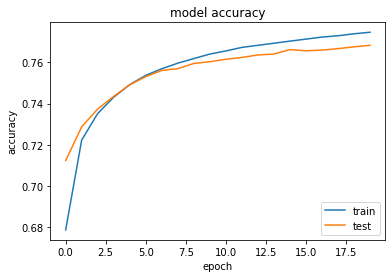

In [24]:
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#### Plot loss 

Plot loss behavior during epochs. 

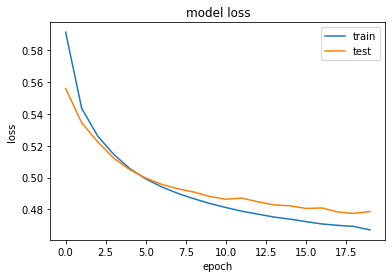

In [25]:
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### ROC and AUC

The article used area under the ROC curve (AUC) as primary metric, and we can do that too. ROC curve plots TPR (True Positive Rate) versus FPR (False Positive Rate). First, we create Receiver Operating Characteristic (ROC) curves to illustrate the performance of the classifier. Then, we can get the AUC values, where larger AUC  indicates higher classification accuracy. 

First we need prediction probabilities, so they can be compared to the actual targets. 

In [26]:
y_validationProbablity = model.predict_proba(X_validation)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Next, we need to compute the TPR and FPR for various threshold values.

In [27]:
FPR, TPR, thresholds = roc_curve(y_validation, y_validationProbablity)

Now, we can plot the ROC curve, that is TPR vs FPR. 

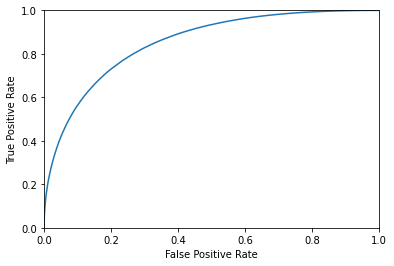

In [28]:
plt.plot(FPR,TPR) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()    

Now, we can calculate area under the curve (AUC). Purely random classifier would have a AUC = 0.5, and perfect classifier would have AUC = 1. 

In [29]:
AUC = roc_auc_score(y_validation, y_validationProbablity) 
AUC

0.8510394827806881

As a single number this doesn't say much, but se can compare it to the AUC obtained with shallow NN model. 

### Save the model 

Save the trained model for future use.  

In [30]:
model.save('deep_nn_lrdec')

INFO:tensorflow:Assets written to: deep_nn_lrdec/assets
